In [1]:
# Summary:
# markov chain variables + 2 phase model outputs 
# Not very good results

In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
# Adding project root and custom functions
from os import listdir, getcwd
from os.path import isfile, join
import sys
from pathlib import Path

def find_root_dir():
    # find config.py
    path = Path(getcwd()).parent
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    while "config.py" not in onlyfiles:
        path = path.parent
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        
    return path

ROOT_DIR = str(find_root_dir())
sys.path.append(ROOT_DIR)

from config import get_project_root
# custom functs
from src.features import build_features
from src.visualization.visualize import plot_confusion_matrix

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

import random
from collections import Counter

from nltk import ngrams
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.multiclass import unique_labels

## Prepare data

In [5]:
ROOT_PATH = get_project_root()
TRAIN_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.train.json"
DEV_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.dev.json"
TEST_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.test.json"

df_train = build_features.to_df(TRAIN_PATH)
df_dev = build_features.to_df(DEV_PATH)
df_test = build_features.to_df(TEST_PATH)

In [6]:
df_train["split"] = "train"
df_dev["split"] = "dev"
df_test["split"] = "test"

In [7]:
# concat df
df = pd.concat([df_train, df_dev, df_test], ignore_index=True)
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split
0,4001000,0,NaN,neutral,neutral,NaN,Sorry to bother you but do you have the 270 te...,What's it called,train
1,4000010,0,neutral,neutral,neutral,Sorry to bother you but do you have the 270 te...,What's it called,Digital design and principles I think,train
2,5000000,0,neutral,neutral,neutral,What's it called,Digital design and principles I think,I don't think so?,train
3,3000020,0,neutral,neutral,neutral,Digital design and principles I think,I don't think so?,I could be wrong,train
4,5000000,0,neutral,neutral,neutral,I don't think so?,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,train
5,3020000,0,neutral,neutral,neutral,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,train
6,5000000,0,neutral,neutral,neutral,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,*book,train
7,5000000,0,neutral,neutral,neutral,You don't need the boom,*book,"If I do have it, I never used it",train
8,4000010,0,neutral,neutral,non-neutral,*book,"If I do have it, I never used it",But you had a good professor,train
9,2110100,0,neutral,non-neutral,neutral,"If I do have it, I never used it",But you had a good professor,I mean you can use the notes,train


In [8]:
# simplify emotion labels
df = df[df.emotion2.isin(["neutral", "joy", "sadness", "anger"])]

In [9]:
df = df.reset_index(drop=True)

In [10]:
# make nan utterances -> empty strings
df.utterance1 = df.utterance1.fillna("")
df.utterance3 = df.utterance3.fillna("")

## Feature transform (onehot)

In [11]:
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

X = df.utterance2
freq = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words='english', lowercase=True)
X = freq.fit_transform(X)

onehot = Binarizer()
X = onehot.fit_transform(X.toarray())

In [12]:
len(freq.vocabulary_)

7741

##  Train test split

In [13]:
# # X as is from above
# y = df.emotion2

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=0, stratify=y)

In [14]:
# # X as is from above
y = df.emotion2
split = df.split

In [15]:
trainIdx = split[split.isin(["train", "dev"])].index.tolist()
testIdx = split[split == "test"].index.tolist()

X_train = [X[i] for i in trainIdx]
X_test = [X[i] for i in testIdx]
y_train = [y[i] for i in trainIdx]
y_test = [y[i] for i in testIdx]

## Fit Model 0

In [16]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')

In [17]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
# predict
y_pred = clf.predict(X_test)

### - Predict state probs of prev state

In [19]:
X = df.utterance1
X = freq.transform(X)
X = onehot.transform(X.toarray())

out = clf.predict_proba(X)
df["prob_emotion1"] = out.tolist()

### - Compute markov probs

In [20]:
# markov transition mat
states = ["anger", "joy", "neutral", "sadness"]
markov_trans = \
[[0.21, 0.12, 0.58, 0.09],
 [0.0, 0.39, 0.57, 0.03],
 [0.01, 0.12, 0.85, 0.02],
 [0.02, 0.12, 0.59, 0.27]]
markov_trans = np.asmatrix(markov_trans)

In [21]:
def mat_op(states, transition):
    out = np.asmatrix(states) * markov_trans
    out = out.tolist()
    return np.asarray(out[0])
    
df["prob_emotion2"] = df.prob_emotion1.apply(lambda x: mat_op(x, markov_trans))

## Feature transform with markov values

In [22]:
# X = df.utterance1
# X = freq.transform(X)
# X = onehot.transform(X.toarray())

In [23]:
# X_markov = df.prob_emotion2.values
# X_markov = np.array(X_markov.tolist())

In [24]:
# X = np.concatenate((X, X_markov), axis=1)

In [25]:
X_markov = df.prob_emotion2.values
X_markov = np.array(X_markov.tolist())
X = X_markov

## Train model 1 with markov values too

In [26]:
# # X as is from above
y = df.emotion2
split = df.split

trainIdx = split[split.isin(["train", "dev"])].index.tolist()
testIdx = split[split == "test"].index.tolist()

X_train = [X[i] for i in trainIdx]
X_test = [X[i] for i in testIdx]
y_train = [y[i] for i in trainIdx]
y_test = [y[i] for i in testIdx]

In [27]:
clf1 = MLPClassifier(random_state=0)
clf1.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [28]:
# predict
y_pred = clf1.predict(X_test)

## Eval predictions

Confusion matrix, without normalization
[[   0    0   37    0]
 [   0    0  458    0]
 [   0    0 1882    0]
 [   0    0   87    0]]


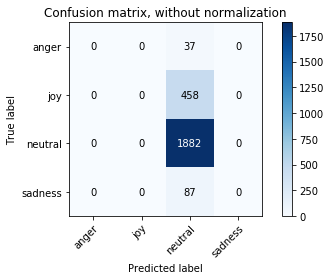

In [29]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')



plt.show()

Normalized confusion matrix
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


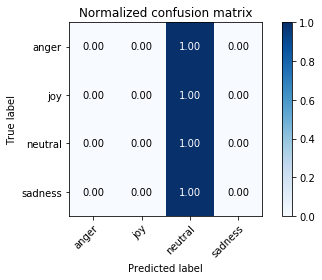

In [30]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        37
         joy       0.00      0.00      0.00       458
     neutral       0.76      1.00      0.87      1882
     sadness       0.00      0.00      0.00        87

   micro avg       0.76      0.76      0.76      2464
   macro avg       0.19      0.25      0.22      2464
weighted avg       0.58      0.76      0.66      2464



/Users/andrewn/Code/emotionx/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Unweighted Accuracy 

In [32]:
print("{:.3f}".format(balanced_accuracy_score(y_test, y_pred)))

0.250


In [33]:
# Summary:
# linearSVC -> 0.534
# linearSVC -> predict_proba (https://www.kaggle.com/c/home-credit-default-risk/discussion/63499)
#           -> Not proper use
#           -> Use actual probabilitic classifier
# Trying LogisticRegression
# LogisticRegression -> 0.496

# Markov chain features
# LR -> LR -> 0.255
# LR -> LinearSVC -> 0.257

# Markov chain probabilities to be evaluated
# Markov probs -> hard classifications -> 0.25